In [1]:
from mcmc import initialize_slab, spin_flip, mcmc_run
from catkit.gen.adsorption import get_adsorption_sites

import numpy as np

In [2]:
# Cu alat from https://www.copper.org/resources/properties/atomic_properties.html
Cu_alat = 3.6147
slab = initialize_slab(Cu_alat)

# get ALL the adsorption sites
# top should have connectivity 1, bridge should be 2 and hollow more like 4
coords, connectivity, sym_idx = get_adsorption_sites(slab, symmetry_reduced=False)
print(f"In pristine slab, there are a total of {len(connectivity)} sites")

# state of each vacancy in slab. for state > 0, it's filled, and that's the index of the adsorbate atom in slab 
state = np.zeros(len(coords), dtype=int)

temp = 300
pot = 2

# perform 5 test iterations
site1 = len(state)-1
site2 = len(state)-2
site3 = len(state)-3

# add to 3 sites
state, slab, energy, _ = spin_flip(state, slab, temp, pot, save_cif=True, iter=1, site_idx=site1, testing=True)
state, slab, energy, _ = spin_flip(state, slab, temp, pot, prev_energy=energy, save_cif=True, iter=2, site_idx=site2, testing=True)
state, slab, energy, _ = spin_flip(state, slab, temp, pot, prev_energy=energy, save_cif=True, iter=3, site_idx=site3, testing=True)


# remove from 2nd site
state, slab, energy, _ = spin_flip(state, slab, temp, pot, prev_energy=energy, save_cif=True, iter=4, site_idx=site2, testing=True)
# remove from 1st site
state, slab, energy, _ = spin_flip(state, slab, temp, pot, prev_energy=energy, save_cif=True, iter=5, site_idx=site1, testing=True)

# add to 1st site again
state, slab, energy, _ = spin_flip(state, slab, temp, pot, prev_energy=energy, save_cif=True, iter=6, site_idx=site1, testing=True)

/Users/xiaochendu/miniconda3/envs/mlenv/lib/python3.9/site-packages/catkit/gen/adsorption.py:60: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.r1_topology = np.array(self.r1_topology)
/Users/xiaochendu/miniconda3/envs/mlenv/lib/python3.9/site-packages/catkit/gen/adsorption.py:61: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.r2_topology = np.array(self.r2_topology)


In pristine slab, there are a total of 64 sites

 we are at iter 1
idx is 63 with connectivity 4 at [ 1.27798944  8.94592609 20.42205   ]
before proposed state is
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
site is not filled, attempting to adsorb
current slab has 64 atoms
proposed slab has 65 atoms
after proposed state is
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 64]

 we are at iter 2
idx is 62 with connectivity 4 at [ 3.83396832  8.94592609 20.42205   ]
before proposed state is
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 64]
site is not filled, attempting to adsorb
current slab has 65 atoms
proposed slab 

In [12]:
from time import perf_counter

start = perf_counter()
# chem pot 0 to less complicate things
# temp in terms of kbT
# no cooling
# 20 runs
history, energy_hist, frac_accept_hist, adsorption_count_hist = mcmc_run(num_runs=20, temp=1, pot=0, alpha=1, slab=None)
stop = perf_counter()
print(f"Time taken = {stop - start} seconds")

initializing slab
In pristine slab, there are a total of 64 sites
running for 64 iterations per run over a total of 20 runs

 we are at iter 1
idx is 33 with connectivity 2 at [ 6.3899472   2.55597888 20.42205   ]
before proposed state is
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
site is not filled, attempting to adsorb
current slab has 64 atoms
proposed slab has 65 atoms
after proposed state is
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0 64  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
prev energy is -210.23276418379697
curr energy is -212.17064187229906
energy diff is -1.937877688502084
potential is 0
delta_N 1
k_b T 1
base probability is 6.943997994184469
state changed!

 we are at iter 2
idx is 42 with connectivity 2 at [ 7.66793665  8.94592609 20.42205   ]
before proposed state is
[ 0  0  0  

In [8]:
from time import perf_counter

start = perf_counter()
# chem pot 0 to less complicate things
# temp in terms of kbT
# 0.8 alpha for 22 runs -> 1e-22 kbT < 300 kb ~= 4.14e-21
history, energy_hist, frac_accept_hist, adsorption_count_hist = mcmc_run(num_runs=20, temp=1, pot=0, alpha=0.8, slab=None)
stop = perf_counter()
print(f"Time taken = {stop - start} seconds")

initializing slab


/Users/xiaochendu/miniconda3/envs/mlenv/lib/python3.9/site-packages/catkit/gen/adsorption.py:60: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.r1_topology = np.array(self.r1_topology)
/Users/xiaochendu/miniconda3/envs/mlenv/lib/python3.9/site-packages/catkit/gen/adsorption.py:61: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.r2_topology = np.array(self.r2_topology)


In pristine slab, there are a total of 64 sites
running for 64 iterations per run over a total of 20 runs

 we are at iter 1
idx is 37 with connectivity 2 at [ 5.11195776  3.83396832 20.42205   ]
before proposed state is
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
site is not filled, attempting to adsorb
current slab has 64 atoms
proposed slab has 65 atoms
after proposed state is
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0 64  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
prev energy is -210.23276418379697
curr energy is -212.170641872299
energy diff is -1.9378776885020272
potential is 0
delta_N 1
k_b T 1.0
base probability is 6.943997994184074
state changed!

 we are at iter 2
idx is 41 with connectivity 2 at [ 6.3899472   7.66793665 20.42205   ]
before proposed state is
[ 0  0  0  0  0  0  0  0  0 

In [21]:
adsorption_count_hist[0]

Counter({1: 4, 2: 15, 4: 10})

/var/folders/85/zd91wmvn09956_q0gy77y3080000gp/T/ipykernel_37961/1225169678.py:22: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


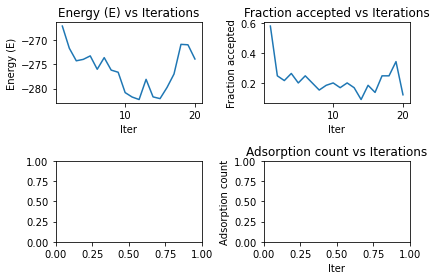

In [22]:
import matplotlib.pyplot as plt
# do the plots
fig, ax = plt.subplots(2, 2)
runs = np.arange(1, 21)
ax[0, 0].plot(runs, energy_hist)
ax[0, 0].set_xlabel("Iter")
ax[0, 0].set_ylabel("Energy (E)")
ax[0, 0].set_title("Energy (E) vs Iterations")


ax[0, 1].plot(runs, frac_accept_hist)
ax[0, 1].set_xlabel("Iter")
ax[0, 1].set_ylabel("Fraction accepted")
ax[0, 1].set_title("Fraction accepted vs Iterations")


# ax[1, 1].plot(runs, adsorption_count_hist)
ax[1, 1].set_xlabel("Iter")
ax[1, 1].set_ylabel("Adsorption count")
ax[1, 1].set_title("Adsorption count vs Iterations")

fig.show()
fig.tight_layout()
# fig.savefig("energy_per_spin")
# fig.savefig("energy_per_spin_10x10")

In [ ]:
# below hasn't been done yet

In [ ]:
from time import perf_counter

# run for a range of temperatures with chain size = 1000 and using a 10 x 10 lattice
temps = np.arange(0.2, 5.2, 0.2)
num_runs = 1000
lattice_width = 10
N = lattice_width**2

energy_results = np.random.rand(len(temps), num_runs)
energy_sq_results = np.random.rand(len(temps), num_runs)
starting_lattice = None

# iterate through different temperatures
for i, temp in reversed(list(enumerate(temps))):
    start = perf_counter()
    history, energy, energy_sq, net_mag, mag_sq = mcmc_run(num_runs=num_runs, temp=temp, \
        lattice_width=lattice_width, lattice=starting_lattice)
    # intitialize with previous temp simulation
    starting_lattice = history[-1]
    stop = perf_counter()
    print(f"Time taken = {stop - start} seconds for temp = {temp}")
    energy_results[i, :] = energy
    energy_sq_results[i, :] = energy_sq

# Also iterate through different chemical potentials

energy_sq_mean = np.mean(energy_sq_results, axis=1)
energy_mean = np.mean(energy_results, axis=1)
energy_mean_sq = np.power(energy_mean, 2)

energy_per_spin = energy_mean/N

# for normalizing the activities
inverse_kbT_sq = 1/np.square(temps)
C_v = (energy_sq_mean - energy_mean_sq)*inverse_kbT_sq
C_v_per_spin = C_v/N

In [ ]:
# do the plots
fig, ax = plt.subplots()
ax.plot(temps, energy_per_spin)
ax.set_xlabel("Temperature (T)")
ax.set_ylabel("Energy per spin (E/N)")
ax.set_title("Energy per spin (E/N) vs Temperature (T)")
fig.show()
# fig.savefig("energy_per_spin")
fig.savefig("energy_per_spin_10x10")

In [ ]:
fig, ax = plt.subplots()
ax.plot(temps, C_v_per_spin)
ax.set_xlabel("Temperature (T)")
ax.set_ylabel("Heat capacity per spin (C/N)")
ax.set_title("Heat capacity per spin (C/N) vs Temperature (T)")
fig.show()
# fig.savefig("c_v_per_spin")
fig.savefig("c_v_per_spin_10x10")